In [1]:
%%time
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

from matplotlib import cm, ticker
import cmocean
import matplotlib.colors as colors
import matplotlib.dates as mdates
import pandas as pd
import seawater as sw
%matplotlib inline

CPU times: user 3.64 s, sys: 3.03 s, total: 6.67 s
Wall time: 55.5 s


In [2]:
yearmin = 2015
savefig = True

In [3]:
#region = 'amundsen' #'basin','nansen','amundsen','eastern'
region = 'basin'

In [4]:
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/'

In [5]:
data_path = '/p/project/chhb19/mueller29/'
regional_path = '/p/scratch/chhb19/mueller29/regional/'

ECR=xr.open_mfdataset((regional_path+'wpbp.fesom.'+region+'.20*1M.nc'))['ECR'].resample(time="1MS").mean(dim="time")
EKE=xr.open_mfdataset((regional_path+'KE.fesom.'+region+'.20*1M.nc'))['EKE'].resample(time="1MS").mean(dim="time")

#data=xr.open_dataset((data_path+'wpbp/wpbp.fesom.nc'))
#data.to_netcdf(data_path+'curl_std_mean_all.nc')
#ice=xr.open_dataset(data_path+'curl_std_mean_AO40/ice_mean_std.nc')
MLD2=xr.open_dataset(regional_path+'MLD2.fesom.timeseries.'+region+'.nc')['MLD2'].resample(time="1MS").mean(dim="time")
a_ice=xr.open_dataset(regional_path+'a_ice.fesom.timeseries.'+region+'.nc')['a_ice'].resample(time="1MS").mean(dim="time")

iceoce=xr.open_dataset(regional_path+'iceoce.fesom.timeseries.'+region+'.nc')['iceoce'].resample(time="1MS").mean(dim="time")
atmoce=xr.open_dataset(regional_path+'atmoce.fesom.timeseries.'+region+'.nc')['atmoce'].resample(time="1MS").mean(dim="time")


In [6]:
MLD2 = MLD2.isel(time=MLD2.time.dt.year>=yearmin)
a_ice = a_ice.isel(time=a_ice.time.dt.year>=yearmin)
ECR = ECR.isel(time=ECR.time.dt.year>=yearmin)
EKE = EKE.isel(time=EKE.time.dt.year>=yearmin)
iceoce = iceoce.isel(time=iceoce.time.dt.year>=yearmin)
atmoce = atmoce.isel(time=atmoce.time.dt.year>=yearmin)


stress = atmoce+iceoce

In [7]:
t_MLD2=np.arange(str(yearmin)+'-01', '2021-02', dtype='datetime64[M]')
z = ECR.nz.values
z1 = EKE.nz1.values
t = ECR.time

In [8]:
c_ax1 = 'k'
c_ax2 = 'b'
c_ax3 = 'r'

In [9]:
def tick_months(step,ax):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(np.arange(1,13,step), months[::step])

In [10]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    fit = fit-fit.mean(dim=dim)
    return da - fit

def clim(ds):
    ds_detr = detrend_dim(ds,"time")
    ds_clim_mean = ds_detr.groupby("time.month").mean("time")
    ds_clim_std = ds_detr.groupby("time.month").std("time")
    ds_anom = ds.groupby("time.month") - ds_clim_mean
    return ds_clim_mean, ds_clim_std, ds_anom

In [11]:
vars = ['EKE','ECR','MLD2','a_ice','stress']
for var in vars:
    ex_stri=var+'_clim,'+var+'_std,'+var+'_anom=clim('+var+')'
    exec(ex_stri)
    
months_MLD2=np.arange(1,14,1)
months=EKE_clim.month

In [12]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


import matplotlib.dates as mdates
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

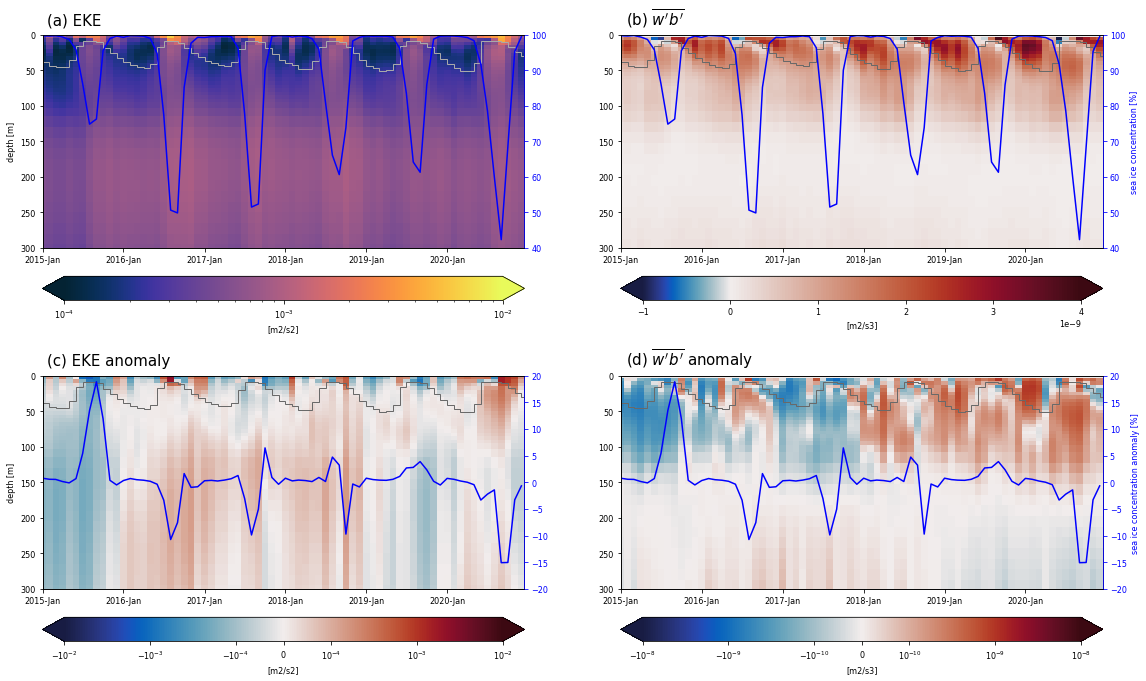

In [18]:
%matplotlib inline
figsize=(19,11.5)

fig, axs = plt.subplots(
            2,
            2,
            figsize=figsize,
        )


ax=axs[0,0]
ax2 = ax.twinx()

pc=ax.pcolormesh(t, z1 , EKE.T , cmap = cmocean.cm.thermal , norm=colors.LogNorm(vmin=1e-4, vmax=1e-2) ,shading='auto')
ax.stairs(-MLD2,t_MLD2,color='darkgrey')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax2.plot(t,100*a_ice, color=c_ax2)
#ax2.set_ylabel('sea ice concentration [%]', fontsize=10, color=c_ax2)
ax2.set_ylim(bottom=40,top=100)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)
ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))     #optional formatting 
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.set_label(r'[m2/s2]')
ax.text(.01, 1.05, '(a) EKE',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)




ax=axs[0,1]
ax2 = ax.twinx()

pc=ax.pcolormesh(t, z , ECR.T ,cmap = cmocean.cm.balance, shading='auto', norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9))
#pc=ax.pcolormesh(t, z , ECR.T ,cmap = cm.RdBu_r, shading='auto', norm=colors.SymLogNorm(linthresh=1e-8/100, linscale=.5, vmin=-1e-8, vmax=1e-8, base=10))

ax.stairs(-MLD2,t_MLD2,color='darkseagreen')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
#ax.set_ylabel('depth [m]', fontsize=10, color='k')
ax2.plot(t,100*a_ice, color=c_ax2)
ax2.set_ylabel('sea ice concentration [%]', color=c_ax2)
ax2.set_ylim(bottom=40,top=100)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)

ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))     #optional formatting 
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.ax.set_xscale('linear')
cbar.set_label(r'[m2/s3]')
ax.text(.01, 1.05, '(b) $\overline{w^{\prime} b^{\prime}}$',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)




ax=axs[1,0]
ax2 = ax.twinx()

pc=ax.pcolormesh(t, z1 ,EKE_anom.T , cmap = cmocean.cm.balance ,shading='auto', norm=colors.SymLogNorm(linthresh=1e-4, linscale=0.5, vmin=-1e-2, vmax=1e-2, base=10))
ax.stairs(-MLD2,t_MLD2,color='darkseagreen')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax2.plot(t,100*a_ice_anom, color=c_ax2)
#ax2.set_ylabel('sea ice concentration anomaly [%]', fontsize=10, color=c_ax2)
ax2.set_ylim(bottom=-20,top=20)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)

ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))     #optional formatting 
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')

cbar.set_label(r'[m2/s2]')
ax.text(.01, 1.05, '(c) EKE anomaly ',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)


ax=axs[1,1]
ax2 = ax.twinx()

pc=ax.pcolormesh(t, z ,ECR_anom.T , cmap = cmocean.cm.balance ,shading='auto',norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=-1e-8, vmax=1e-8, base=10))
ax.stairs(-MLD2,t_MLD2,color='darkseagreen')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
#ax.set_ylabel('depth [m]', fontsize=10, color='k')
ax2.plot(t,100*a_ice_anom, color=c_ax2)
ax2.set_ylabel('sea ice concentration anomaly [%]', color=c_ax2)
ax2.set_ylim(bottom=-20,top=20)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)

ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))     #optional formatting 
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.set_label(r'[m2/s3]')
ax.text(.01, 1.05, '(d) $\overline{w^{\prime} b^{\prime}}$ anomaly',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)


if savefig == True:
    fig.set_figwidth(19, forward=True)
    fig.savefig(plot_path + 'F3_hovmoeller.png', dpi=600, format='png',bbox_inches='tight')

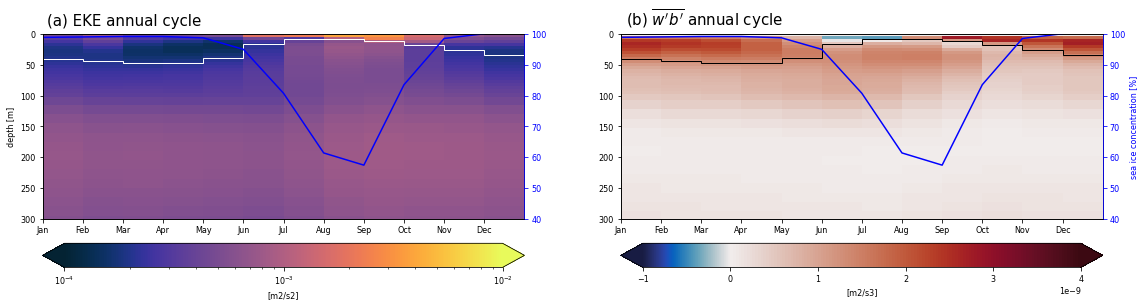

In [14]:
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
        )

ax=axs[0]
ax2 = ax.twinx()

pc=ax.pcolormesh(months+.5, z1 , EKE_clim.T , cmap = cmocean.cm.thermal ,shading='auto',norm=colors.LogNorm(vmin=1e-4, vmax=1e-2))
ax.stairs(-MLD2_clim,months_MLD2,color='w')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
tick_months(1,ax)
ax2.plot(months,100*a_ice_clim, color=c_ax2)
#ax2.set_ylabel('sea ice concentration [%]', fontsize=10, color=c_ax2)
ax2.set_ylim(bottom=40,top=100)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.set_label(r'[m2/s2]')
ax.text(.01, 1.05, '(a) EKE annual cycle',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)

ax=axs[1]
ax2 = ax.twinx()

pc=ax.pcolormesh(months+.5, z , ECR_clim.T , cmap = cmocean.cm.balance ,shading='auto',norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9))
#pc=ax.pcolormesh(months+.5, z , ECR_clim.T , cmap = cm.RdBu_r ,shading='auto',norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=-1e-8, vmax=1e-8, base=10))

ax.stairs(-MLD2_clim,months_MLD2,color='k')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
#ax.set_ylabel('depth [m]', fontsize=10, color='k')
tick_months(1,ax)
ax2.plot(months,100*a_ice_clim, color=c_ax2)
ax2.set_ylabel('sea ice concentration [%]', color=c_ax2)
ax2.set_ylim(bottom=40,top=100)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.set_label(r'[m2/s3]')
cbar.ax.set_xscale('linear')
ax.text(.01, 1.05, '(b) $\overline{w^{\prime} b^{\prime}}$ annual cycle',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)
if savefig == True:
    fig.set_figwidth(19, forward=True)
    fig.savefig(plot_path + 'supplement_annual_cycle.png', dpi=600, format='png',bbox_inches='tight')

/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


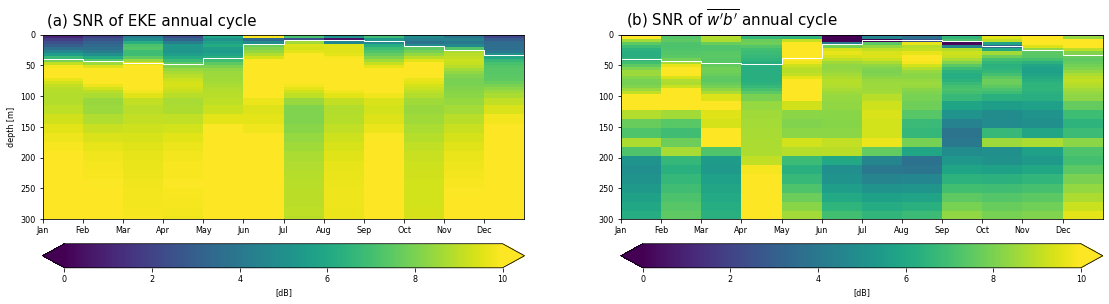

In [112]:
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
        )

ax=axs[0]

pc=ax.pcolormesh(months+.5, z1 , 10*np.log10(EKE_clim/EKE_std).T , cmap = cm.viridis ,shading='auto',vmin=0, vmax=10)
ax.stairs(-MLD2_clim,months_MLD2,color='w')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
tick_months(1,ax)

cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.set_label(r'[dB]')
ax.text(.01, 1.05, '(a) SNR of EKE annual cycle',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)

ax=axs[1]

pc=ax.pcolormesh(months+.5, z , 10*np.log10(np.abs(ECR_clim)/ECR_std).T , cmap = cm.viridis ,shading='auto',vmin=0, vmax=10)
#pc=ax.pcolormesh(months+.5, z , ECR_clim.T , cmap = cm.RdBu_r ,shading='auto',norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=-1e-8, vmax=1e-8, base=10))

ax.stairs(-MLD2_clim,months_MLD2,color='w')
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
#ax.set_ylabel('depth [m]', fontsize=10, color='k')
tick_months(1,ax)
cbar=plt.colorbar(pc,ax=ax,orientation="horizontal", pad=.1,extend='both')
cbar.set_label(r'[dB]')
cbar.ax.set_xscale('linear')
ax.text(.01, 1.05, '(b) SNR of $\overline{w^{\prime} b^{\prime}}$ annual cycle',zorder=100, transform=ax.transAxes, size=MEDIUM_SIZE)
if savefig == True:
    fig.set_figwidth(19, forward=True)
    fig.savefig(plot_path + 'supplement_annual_cycle.png', dpi=600, format='png',bbox_inches='tight')

/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


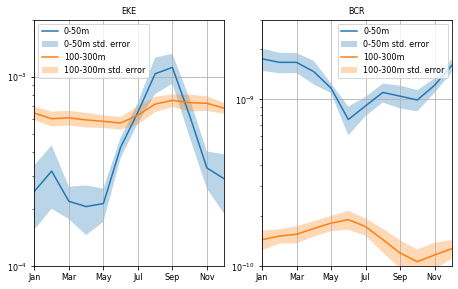

In [17]:
%matplotlib inline
# figsize=(19,11.5)
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
        )


top = 0
bottom = 50
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)

EKE_anom_mean=EKE_clim[:,iz].mean(axis=1)
ECR_anom_mean=ECR_clim[:,iz1].mean(axis=1)
EKE_anom_std=EKE_std[:,iz].mean(axis=1)/np.sqrt(6)
ECR_anom_std=ECR_std[:,iz1].mean(axis=1)/np.sqrt(6)

ax=axs[0]
line11=ax.plot(months,EKE_anom_mean,label='0-50m')
shade11=ax.fill_between(months, EKE_anom_mean-1.96*EKE_anom_std, EKE_anom_mean+1.96*EKE_anom_std, alpha=0.3, label='0-50m std. error')

ax=axs[1]
line12=ax.plot(months,ECR_anom_mean,label='0-50m')
shade12=ax.fill_between(months, ECR_anom_mean-1.96*ECR_anom_std, ECR_anom_mean+1.96*ECR_anom_std, alpha=0.3, label='0-50m std. error')

top = 100
bottom = 300
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)

EKE_anom_mean=EKE_clim[:,iz].mean(axis=1)
ECR_anom_mean=ECR_clim[:,iz1].mean(axis=1)
EKE_anom_std=EKE_std[:,iz].mean(axis=1)/np.sqrt(6)
ECR_anom_std=ECR_std[:,iz1].mean(axis=1)/np.sqrt(6)

ax=axs[0]
line21=ax.plot(months,EKE_anom_mean,label='100-300m')
shade21=ax.fill_between(months, EKE_anom_mean-1.96*EKE_anom_std, EKE_anom_mean+1.96*EKE_anom_std, alpha=0.3, label='100-300m std. error')

ax=axs[1]
line22=ax.plot(months,ECR_anom_mean,label='100-300m')
shade22=ax.fill_between(months, ECR_anom_mean-1.96*ECR_anom_std, ECR_anom_mean+1.96*ECR_anom_std, alpha=0.3, label='100-300m std. error')


ax=axs[0]

ax.set_yscale('log')
ax.set_ylim([1e-4,2e-3])
ax.legend()
ax.set_title('EKE')
ax.grid()
ax.set_xlim([1,12])
tick_months(2,ax)

ax=axs[1]
ax.set_yscale('log')
ax.set_ylim([1e-10,3e-9])
ax.legend()
ax.set_title('BCR')
ax.set_xlim([1,12])
ax.grid()
tick_months(2,ax)

if savefig:
    fig.savefig(plot_path + 'S3_seasonal_cycles.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


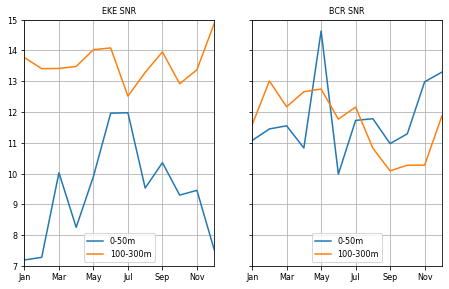

In [122]:
%matplotlib inline
# figsize=(19,11.5)
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
            sharey=True
        )


top = 0
bottom = 50
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)

EKE_anom_mean=EKE_clim[:,iz].mean(axis=1)
ECR_anom_mean=ECR_clim[:,iz1].mean(axis=1)
EKE_anom_std=EKE_std[:,iz].mean(axis=1)/np.sqrt(6)
ECR_anom_std=ECR_std[:,iz1].mean(axis=1)/np.sqrt(6)

ax=axs[0]
line11=ax.plot(months,10*np.log10(np.abs(EKE_anom_mean)/EKE_anom_std),label='0-50m')

ax=axs[1]
line12=ax.plot(months,10*np.log10(np.abs(ECR_anom_mean)/ECR_anom_std),label='0-50m')

top = 100
bottom = 300
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)

EKE_anom_mean=EKE_clim[:,iz].mean(axis=1)
ECR_anom_mean=ECR_clim[:,iz1].mean(axis=1)
EKE_anom_std=EKE_std[:,iz].mean(axis=1)/np.sqrt(6)
ECR_anom_std=ECR_std[:,iz1].mean(axis=1)/np.sqrt(6)

ax=axs[0]
line21=ax.plot(months,10*np.log10(np.abs(EKE_anom_mean)/EKE_anom_std),label='100-300m')

ax=axs[1]
line22=ax.plot(months,10*np.log10(np.abs(ECR_anom_mean)/ECR_anom_std),label='100-300m')


ax=axs[0]

ax.set_ylim([7,15])
ax.legend(loc='lower center',fontsize=SMALL_SIZE)
ax.set_title('EKE SNR')
ax.grid()
ax.set_xlim([1,12])
tick_months(2,ax)

ax=axs[1]
ax.set_ylim([7,15])
ax.legend(loc='lower center',fontsize=SMALL_SIZE)
ax.set_title('BCR SNR')
ax.set_xlim([1,12])
ax.grid()
tick_months(2,ax)

if savefig:
    fig.savefig(plot_path + 'S3_seasonal_cycles_SNR.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title



In [83]:
# Define a function to format the tick labels in scientific notation
def format_sci_tick(value, tick_number):
    return "{:.1e}".format(value)

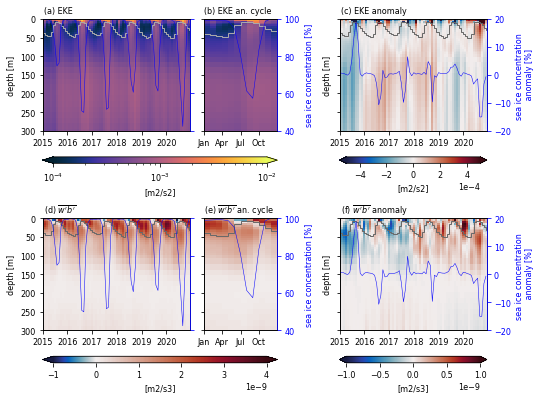

In [105]:
%matplotlib inline
# figsize=(19,11.5)
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

fig, axs = plt.subplots(
            2,
            3,
            figsize=figsize,
            sharey=True,
            gridspec_kw={'width_ratios': [2,1,2]}
        )
fig.patch.set_facecolor('white')


ax=axs[0,0]
ax2 = ax.twinx()
pc_eke=ax.pcolormesh(t, z1 , EKE.T , cmap = cmocean.cm.thermal , norm=colors.LogNorm(vmin=1e-4, vmax=1e-2) ,shading='auto')
ax.stairs(-MLD2,t_MLD2,color='darkgrey',linewidth=1)
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax2.plot(t,100*a_ice, color=c_ax2,linewidth=.5)
ax2.set_ylim(bottom=40,top=100)
ax2.set_yticks(np.arange(40,120,20))

ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)
ax2.yaxis.set_ticklabels([])


ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     #optional formatting 
ax.text(.01, 1.05, '(a) EKE',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)

ax=axs[0,1]
ax2 = ax.twinx()

pc_eke=ax.pcolormesh(months+.5, z1 , EKE_clim.T , cmap = cmocean.cm.thermal ,shading='auto',norm=colors.LogNorm(vmin=1e-4, vmax=1e-2))
ax.stairs(-MLD2_clim,months_MLD2,color='darkgrey',linewidth=1)
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
tick_months(3,ax)
ax2.plot(months,100*a_ice_clim, color=c_ax2,linewidth=.5)
ax2.set_ylabel('sea ice concentration [%]', color=c_ax2)
ax2.set_ylim(bottom=40,top=100)
ax2.set_yticks(np.arange(40,120,20))
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)
ax.text(.01, 1.05, '(b) EKE an. cycle',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


ax=axs[0,2]
ax2 = ax.twinx()
# ax3 = ax.twinx()

#pc_eke_anom=ax.pcolormesh(t, z1 ,EKE_anom.T , cmap = cmocean.cm.balance ,shading='auto', norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, vmin=-1e-2, vmax=1e-2, base=10))
pc_eke_anom=ax.pcolormesh(t, z1 ,EKE_anom.T , cmap = cmocean.cm.balance ,shading='auto', norm=colors.TwoSlopeNorm(vcenter=0., vmin=-5e-4, vmax=5e-4))

ax.stairs(-MLD2,t_MLD2,color='dimgrey',linewidth=1)
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax2.plot(t,100*a_ice_anom, color=c_ax2,linewidth=.5)
ax2.set_ylabel('sea ice concentration \n anomaly [%]', color=c_ax2)
ax2.set_ylim(bottom=-20,top=20)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)

ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     #optional formatting 

ax.text(.01, 1.05, '(c) EKE anomaly ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)

#ax3.plot(t[t.dt.month==6],EKE_anom.isel(nz1=(z1>=100)&(z1<=300)).mean(dim='nz1').groupby(t.dt.year).mean(dim='time'))
# ax3.stairs(EKE_anom.isel(nz1=(z1>=100)&(z1<=300)).mean(dim='nz1').groupby(t.dt.year).mean(dim='time'),t_annual,color='cyan',linewidth=2)

# ax3.spines['left'].set_color('cyan')
# ax3.spines.left.set_position(("axes", 1.2))
# ax3.tick_params(axis='y', colors='cyan')
# ax3.set_ylim(bottom=-1e-4,top=1e-4)


ax=axs[1,0]
ax2 = ax.twinx()

pc_ecr=ax.pcolormesh(t, z , ECR.T ,cmap = cmocean.cm.balance, shading='auto', norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9))

ax.stairs(-MLD2,t_MLD2,color='dimgrey',linewidth=1)
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax2.plot(t,100*a_ice, color=c_ax2,linewidth=.5)
ax2.set_ylim(bottom=40,top=100)
ax2.set_yticks(np.arange(40,120,20))
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)
ax2.yaxis.set_ticklabels([])

ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     #optional formatting 


ax.text(.01, 1.05, '(d) $\overline{w^{\prime} b^{\prime}}$',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


ax=axs[1,1]
ax2 = ax.twinx()

pc_ecr=ax.pcolormesh(months+.5, z , ECR_clim.T , cmap = cmocean.cm.balance ,shading='auto',norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9))

ax.stairs(-MLD2_clim,months_MLD2,color='dimgrey',linewidth=1)
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
tick_months(3,ax)
ax2.plot(months,100*a_ice_clim, color=c_ax2,linewidth=.5)
ax2.set_ylabel('sea ice concentration [%]', color=c_ax2)
ax2.set_ylim(bottom=40,top=100)
ax2.set_yticks(np.arange(40,120,20))

ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)



ax.text(.01, 1.05, '(e) $\overline{w^{\prime} b^{\prime}}$ an. cycle',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


ax=axs[1,2]
ax2 = ax.twinx()

#pc_ecr_anom=ax.pcolormesh(t, z ,ECR_anom.T , cmap = cmocean.cm.balance ,shading='auto',norm=colors.SymLogNorm(linthresh=1e-10, linscale=1, vmin=-1e-8, vmax=1e-8, base=10))
pc_ecr_anom=ax.pcolormesh(t, z ,ECR_anom.T , cmap = cmocean.cm.balance ,shading='auto',norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=1e-9))

ax.stairs(-MLD2,t_MLD2,color='dimgrey',linewidth=1)
ax.invert_yaxis()
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax2.plot(t,100*a_ice_anom, color=c_ax2,linewidth=.5)
ax2.set_ylabel('sea ice concentration \n anomaly [%]', color=c_ax2)
ax2.set_ylim(bottom=-20,top=20)
ax2.spines['right'].set_color(c_ax2)
ax2.tick_params(axis='y', colors=c_ax2)

ax.set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     #optional formatting 

ax.text(.01, 1.05, '(f) $\overline{w^{\prime} b^{\prime}}$ anomaly',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)

#manually adjust positions of subplots for tight layout    
chartBox_top=axs[0,0].get_position()
chartBox_bot=axs[1,0].get_position()
            
for ii in range(3):
    chartBox = axs[1,ii].get_position()
    axs[1,ii].set_position([chartBox.x0, 
                  chartBox.y0-.2, #adjust vertical position of lower plots
                  chartBox.width,
                  chartBox.height])


for d in range(2):
    chartBox = axs[d,1].get_position()
    axs[d,1].set_position([chartBox.x0-.02, #adjust horizontal position of the two middle plots
        chartBox.y0,
        chartBox.width,
        chartBox.height])        
    
    chartBox = axs[d,2].get_position()
    axs[d,2].set_position([chartBox.x0+.05, #adjust horizontal position of the two right plots
        chartBox.y0,
        chartBox.width,
        chartBox.height]) 
    

#add colorbars
chartBox1 = axs[0,0].get_position()
chartBox2 = axs[0,1].get_position()
width = chartBox2.x0+chartBox2.width-chartBox1.x0
cbar_ax = fig.add_axes([chartBox1.x0, chartBox1.y0-.1, width, 0.02])
cbar_eke=fig.colorbar(pc_eke,cax=cbar_ax,orientation="horizontal",extend='both')
cbar_eke.set_label(r'[m2/s2]')

chartBox1 = axs[0,2].get_position()
width = chartBox1.width
cbar_ax = fig.add_axes([chartBox1.x0, chartBox1.y0-.1, width, 0.02])
cbar_eke_anom=fig.colorbar(pc_eke_anom,cax=cbar_ax,orientation="horizontal",extend='both')
cbar_eke_anom.set_ticks(np.arange(-4e-4,6e-4,2e-4))
#cbar_eke_anom.ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False,useMathText=True))
#cbar_eke_anom.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
cbar_eke_anom.ax.xaxis.get_major_formatter().set_powerlimits((0, 0))

#for label in cbar_eke_anom.ax.xaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
cbar_eke_anom.set_label(r'[m2/s2]')

chartBox1 = axs[1,0].get_position()
chartBox2 = axs[1,1].get_position()
width = chartBox2.x0+chartBox2.width-chartBox1.x0
cbar_ax = fig.add_axes([chartBox1.x0, chartBox1.y0-.1, width, 0.02])
cbar_ecr=fig.colorbar(pc_ecr,cax=cbar_ax,orientation="horizontal",extend='both')
cbar_ecr.set_label(r'[m2/s3]')
cbar_ecr.ax.set_xscale('linear')

chartBox1 = axs[1,2].get_position()
width = chartBox1.width
cbar_ax = fig.add_axes([chartBox1.x0, chartBox1.y0-.1, width, 0.02])
cbar_ecr_anom=fig.colorbar(pc_ecr_anom,cax=cbar_ax,orientation="horizontal",extend='both')
#for label in cbar_ecr_anom.ax.xaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
cbar_ecr_anom.set_label(r'[m2/s3]')
cbar_ecr_anom.ax.set_xscale('linear')


if savefig:
    fig.savefig(plot_path + 'F3_hovmoeller_and_seasonal.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

In [ ]:
#save things for data publication
out_path = '/p/project/chhb19/mueller29/data_EKE_paper/'

dout = xr.Dataset(
    data_vars=dict(
        EKE=EKE,
    ),
    attrs=dict(
        description="eddy kinetic energy",
        units="m2/s2",
    ),
)    
dout.to_netcdf(out_path+'Fig3_EKE.nc')

dout = xr.Dataset(
    data_vars=dict(
        BCR=ECR,
    ),
    attrs=dict(
        description="baroclinic conversion rate",
        units="m2/s3",
    ),
)    
dout.to_netcdf(out_path+'Fig3_BCR.nc')

dout = xr.Dataset(
    data_vars=dict(
        MLD=MLD2,
    ),
    attrs=dict(
        description="mixed layer depth",
        units="m",
    ),
) 
dout.to_netcdf(out_path+'Fig3_MLD.nc')

dout = xr.Dataset(
    data_vars=dict(
        a_ice=a_ice,
    ),
    attrs=dict(
        description="sea ice concentration",
        units="",
    ),
) 
dout.to_netcdf(out_path+'Fig3_a_ice.nc')

